In [1]:
# Imports
import numpy as np
import pandas as pd
import random
from sklearn.metrics.pairwise import cosine_similarity
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [14]:
# Generate synthetic topic probabilities
def generate_topic_probs(num_topics, num_sentences, topic_shift_interval):
    topic_probs = []

    for i in range(num_sentences):
        if i % topic_shift_interval == 0:
            current_topic = np.random.dirichlet(np.ones(num_topics))
        
        noise = np.random.uniform(0.01, 0.05, num_topics)
        noisy_current_topic = current_topic + noise
        noisy_current_topic /= np.sum(noisy_current_topic)
        
        topic_probs.append(noisy_current_topic)

    return topic_probs

# Parameters for the synthetic dataset
num_topics = 5
num_sentences = 50
topic_shift_interval = 10

# Create the synthetic dataset
topic_probs = generate_topic_probs(num_topics, num_sentences, topic_shift_interval)

testing_df = pd.DataFrame({"sentence_no":[i for i in range(len(topic_probs))], "topic_probs": topic_probs})
testing_df.head()

,sentence_no,topic_probs
0,0,"[0.11488977693947425, 0.07556929413561232, 0.3..."
1,1,"[0.12588205738893263, 0.06192220189128136, 0.3..."
2,2,"[0.10636248433362813, 0.06788669239406611, 0.3..."
3,3,"[0.11559128477893407, 0.06590257386745842, 0.3..."
4,4,"[0.12698960573300022, 0.07175385359960011, 0.3..."


## Make algo from paper

In [15]:
# Make function for defining windows and iterating over transcript and outputting sequence of cosine similarity scores (cp)

def find_window(dataframe, window_size=3):
    """dataframe must have feature topic_probs
    returns: cosine similarities for full transcript"""
    transcript_cosine_similarities = []  # np.zeros(shape=(len(dataframe)-window_size*2, 1))

    for p in range(window_size, len(dataframe)-window_size):
        w_l = dataframe.topic_probs[p-window_size:p]
        w_r = dataframe.topic_probs[p:p+window_size]

        # add probability vectors in blocks
        w_l_added = np.add.reduce(w_l)
        w_r_added = np.add.reduce(w_r)

        # compute cosine similarity between summed vecors of the windows
        transcript_cosine_similarities.append(np.dot(w_l_added, w_r_added)/(np.linalg.norm(w_l_added) * np.linalg.norm(w_r_added)))
        
    return np.array(transcript_cosine_similarities)

test = find_window(testing_df)

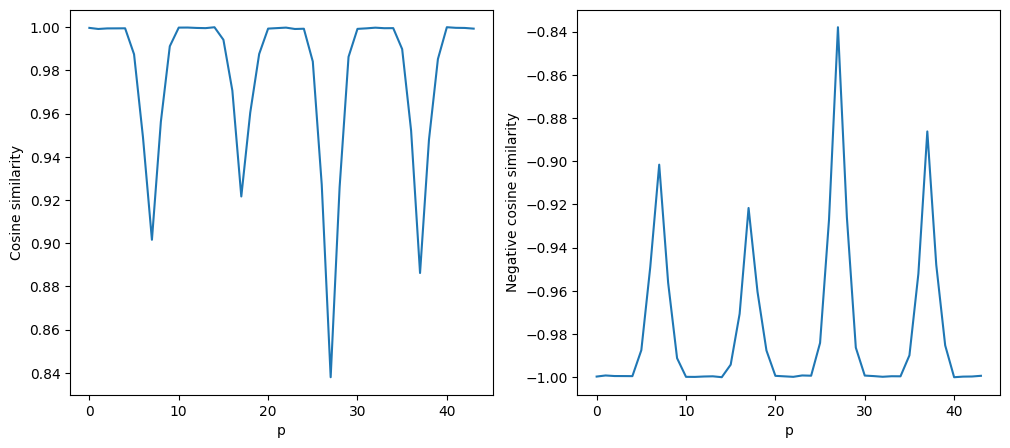

Minima at sentence 10, p:7, value: 0.901559612112001
Minima at sentence 20, p:17, value: 0.9216100842339607
Minima at sentence 30, p:27, value: 0.8379320970690297
Minima at sentence 40, p:37, value: 0.8861747634486266


In [42]:
# Plot negative cosine similarities and find minimas
test_neg = test*-1

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.lineplot(test, ax=axs[0])
axs[0].set_xlabel("p")
axs[0].set_ylabel("Cosine similarity")

sns.lineplot(test_neg, ax=axs[1])
axs[1].set_xlabel("p")
axs[1].set_ylabel("Negative cosine similarity")
plt.show()

# Find index of minimas
minimas, properties = find_peaks(test_neg, height=-0.999, threshold=0.001, prominence=0.0001)

window_size = 3
for position in minimas:
    print(f"Minima at sentence {position+window_size}, p:{position}, value: {test[position]}")

In [56]:
# At each minima calculate depth score (dp)
def hl(p, cos_sims):
    max_val = cos_sims[p]
    for i in range(p-1, 0, -1):  # Change -1 to 0
        if cos_sims[i] > max_val:
            max_val = cos_sims[i]
        else:
            break
    return max_val


def hr(p, cos_sims):
    max_val = cos_sims[p]
    for i in range(p+1, len(cos_sims)):
        if cos_sims[i] > max_val:
            max_val = cos_sims[i]
        else:
            break
    return max_val


def depth_scores(cos_sims, minimas):
    scores = []
    for p in minimas:
        dp = 0.5 * (hl(p, cos_sims) + hr(p, cos_sims) - cos_sims[p]*2)
        scores.append(dp)
    return scores


dep_scores = depth_scores(test, minimas)
dep_scores

[0.09807625596485037,
 0.07825424836528816,
 0.16157559230789853,
 0.11357525190491113]

In [64]:
# Set depth score threshold value and output the dp:s that are higher than it

def segment_boundaries(depth_scores, minimas_list, window_size):
    threshold = np.mean(dep_scores) - (np.std(dep_scores)/2)
    boundaries = []
    for index, score in enumerate(depth_scores):
        if score >= threshold:
            boundaries.append(minimas_list[index] + window_size)
            print(f"Boundary at sentence {minimas_list[index] + window_size}, p:{minimas_list[index]}, depth score: {score}")
    return boundaries

segment_boundaries(dep_scores, minimas, window_size=3)

Boundary at sentence 10, p:7, depth score: 0.09807625596485037
Boundary at sentence 30, p:27, depth score: 0.16157559230789853
Boundary at sentence 40, p:37, depth score: 0.11357525190491113


[10, 30, 40]

# GPT

In [ ]:
def similarity_matrix(topic_probs):
    """
    Calculate the similarity matrix between consecutive sentences.

    Parameters:
    topic_probs (np.array): An array containing topic probability distributions for each sentence.

    Returns:
    np.array: A similarity matrix containing cosine similarities between consecutive sentences.
    """
    # Create an array of consecutive topic probability pairs
    consecutive_topic_probs = np.stack((topic_probs[:-1], topic_probs[1:]), axis=1)
    
    # Compute the cosine similarities between the consecutive topic probability pairs
    consecutive_similarities = cosine_similarity(consecutive_topic_probs.reshape(-1, consecutive_topic_probs.shape[-1])).reshape(-1, 2)[:, 1]
    
    # Fill the diagonal of the similarity matrix with the computed consecutive similarities
    sim_matrix = np.diag(consecutive_similarities)
    
    return sim_matrix

def compute_cost_traceback_matrices(sim_matrix):
    """
    Compute the cost matrix and traceback matrix for dynamic programming.

    Parameters:
    sim_matrix (np.array): A similarity matrix containing cosine similarities between consecutive sentences.

    Returns:
    tuple: A tuple containing the cost matrix and the traceback matrix.
    """
    n = sim_matrix.shape[0]
    cost_matrix = np.zeros((n, n))
    traceback_matrix = np.zeros((n, n), dtype=int)

    # Calculate cost and traceback matrices using dynamic programming
    for j in range(n):
        for i in range(j, -1, -1):
            if i == j:
                cost_matrix[i, j] = sim_matrix[i, j]
            else:
                local_costs = cost_matrix[i, :j] + cost_matrix[:j, j]
                cost_matrix[i, j] = sim_matrix[i, j] + np.min(local_costs[i:j])
                traceback_matrix[i, j] = i + np.argmin(local_costs[i:j])

    return cost_matrix, traceback_matrix

def backtrack_iterative(traceback_matrix):
    i, j = 0, traceback_matrix.shape[0] - 1
    stack = [(i, j)]
    segments = []

    while stack:
        i, j = stack.pop()
        if i < j:
            k = traceback_matrix[i, j]
            segments.append(k)
            stack.append((i, k - 1))
            stack.append((k + 1, j))

    return sorted(segments)

def topic_tiling_bertopic(topic_probs):
    sim_matrix = similarity_matrix(topic_probs)
    cost_matrix, traceback_matrix = compute_cost_traceback_matrices(sim_matrix)
    segments = backtrack_iterative(traceback_matrix)
    
    return segments

In [ ]:
# Test the topic_tiling_bertopic function with the synthetic dataset
segments = topic_tiling_bertopic(topic_probs)
print("Segment boundaries:", segments)

Segment boundaries: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,

In [ ]:

len(segments)

4801

### V2

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def similarity_matrix(topic_probs):
    return cosine_similarity(topic_probs[:-1], topic_probs[1:])

def compute_cost_traceback_matrices(sim_matrix, penalty):
    n = sim_matrix.shape[0]
    cost_matrix = np.zeros((n, n))
    traceback_matrix = np.zeros((n, n), dtype=int)

    for j in range(n):
        for i in range(j, -1, -1):
            if i == j:
                cost_matrix[i, j] = sim_matrix[i, j]
            else:
                segment_costs = cost_matrix[i, :j] + cost_matrix[:j, j] + penalty
                min_cost_idx = i + np.argmin(segment_costs[i:j])
                cost_matrix[i, j] = sim_matrix[i, j] + segment_costs[min_cost_idx]
                traceback_matrix[i, j] = min_cost_idx

    return cost_matrix, traceback_matrix


def backtrack_iterative(traceback_matrix):
    i, j = 0, traceback_matrix.shape[0] - 1
    stack = [(i, j)]
    segments = []

    while stack:
        i, j = stack.pop()
        if i < j:
            k = traceback_matrix[i, j]
            segments.append(k)
            stack.append((i, k - 1))
            stack.append((k + 1, j))

    return sorted(segments)

def topic_tiling_bertopic_iterative(topic_probs, penalty=0.5):
    sim_matrix = similarity_matrix(topic_probs)
    cost_matrix, traceback_matrix = compute_cost_traceback_matrices(sim_matrix, penalty)
    segments = backtrack_iterative(traceback_matrix)

    return segments


In [ ]:
segments = topic_tiling_bertopic_iterative(topic_probs, penalty=10000)
print("Segment boundaries:", segments)

Segment boundaries: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


### V3

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def similarity_matrix(topic_probs):
    return cosine_similarity(topic_probs[:-1], topic_probs[1:])

def calculate_depth_scores(sim_matrix, window_size=3):
    n = sim_matrix.shape[0]
    depth_scores = np.zeros(n)

    for i in range(window_size, n - window_size):
        left_mean = np.mean([sim_matrix[i - k, i - k - 1] for k in range(window_size)])
        right_mean = np.mean([sim_matrix[i + k, i + k + 1] for k in range(window_size)])
        depth_scores[i] = left_mean + right_mean - 2 * sim_matrix[i, i + 1]

    return depth_scores

def find_segment_boundaries(depth_scores, threshold):
    boundaries = np.argwhere(depth_scores > threshold).flatten().tolist()
    return [0] + boundaries + [len(depth_scores)]

def topic_tiling_bertopic(topic_probs, window_size=3, threshold=0.2):
    sim_matrix = similarity_matrix(topic_probs)
    depth_scores = calculate_depth_scores(sim_matrix, window_size)
    segment_boundaries = find_segment_boundaries(depth_scores, threshold)
    return segment_boundaries


In [ ]:
def moving_average(topic_probs, window_size=5):
    cumsum = np.cumsum(topic_probs, axis=0)
    cumsum[window_size:] = cumsum[:-window_size] - cumsum[window_size - 1:-1]
    return cumsum[window_size - 1:] / window_size


In [ ]:
smoothed_topic_probs = moving_average(topic_probs, window_size=5)
segment_boundaries = topic_tiling_bertopic(smoothed_topic_probs, window_size=3, threshold=0.1)
print("Segment boundaries:", segment_boundaries)

Segment boundaries: [0, 95]


In [ ]:
segment_boundaries = topic_tiling_bertopic(topic_probs, window_size=4, threshold=0.06)
print("Segment boundaries:", segment_boundaries)

Segment boundaries: [0, 14, 25, 56, 73, 99]
